In [1]:
import glob
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from confidence_interval import (
    calculate_confidence_interval,
    compare_model_accuracies,
    compare_logo_cv_models,
)
from charts import model_swarmplot, plot_model_comparison_table


model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]
train_test_suites = ["BuildCross-All.csv", "Combined-All.csv", "CpuRec-All.csv"]
cross_validation_suites = [
    "LOGO-*.csv",
    "KFold-all.csv",
]
directory = "./input/"

### Crossvalidation Comparisons


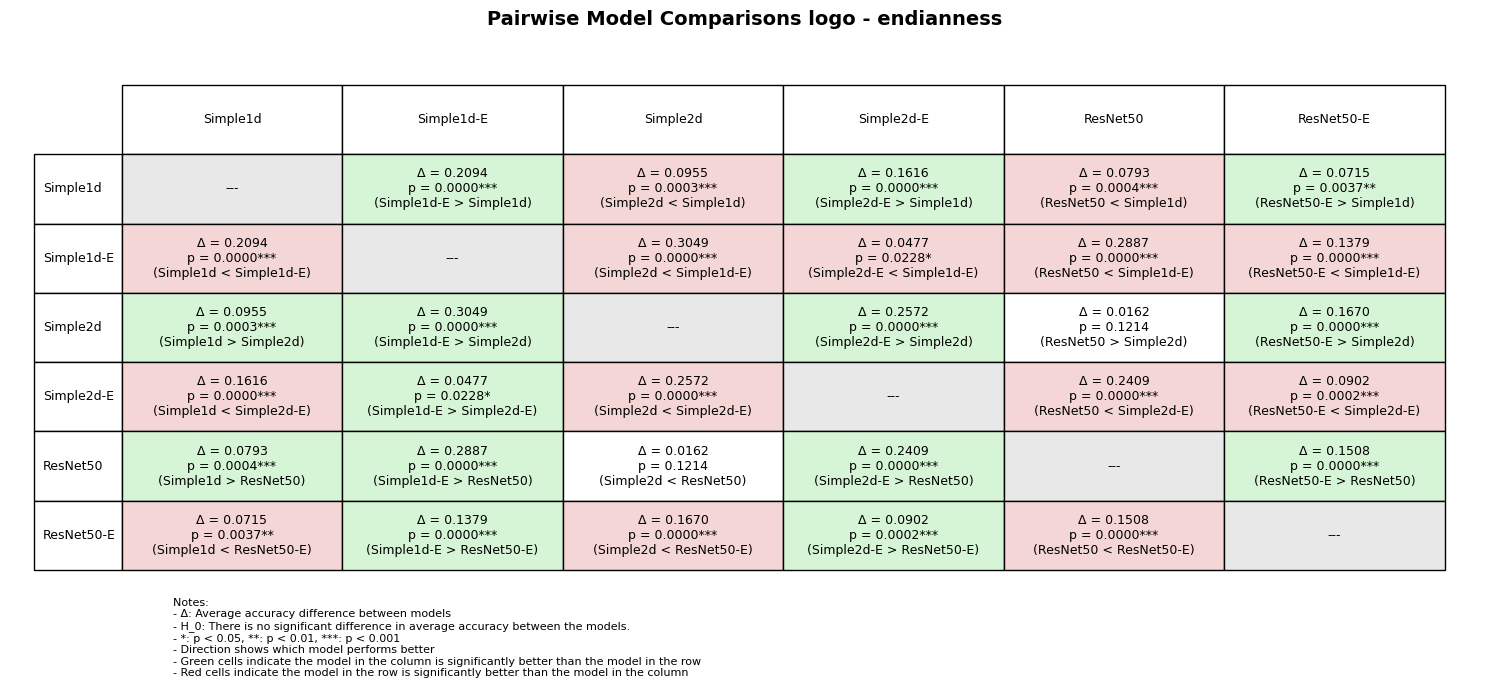

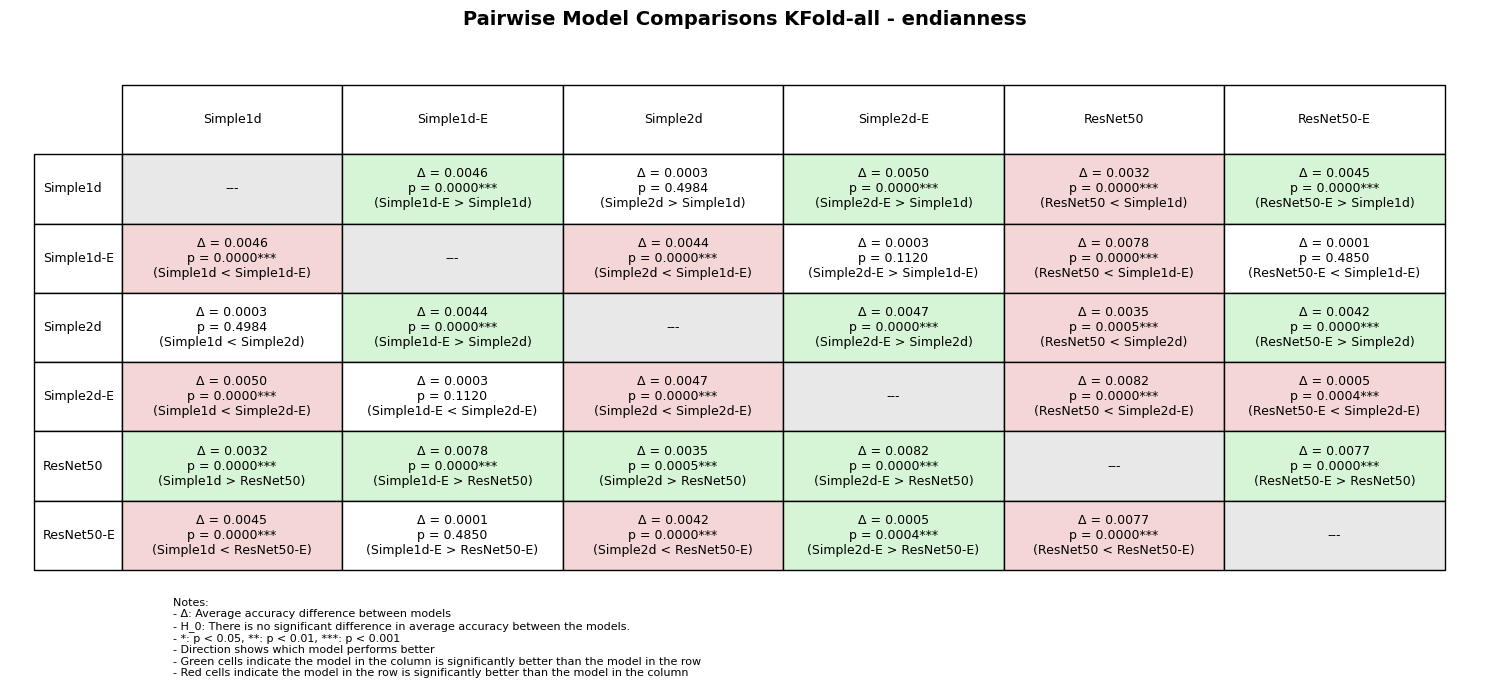

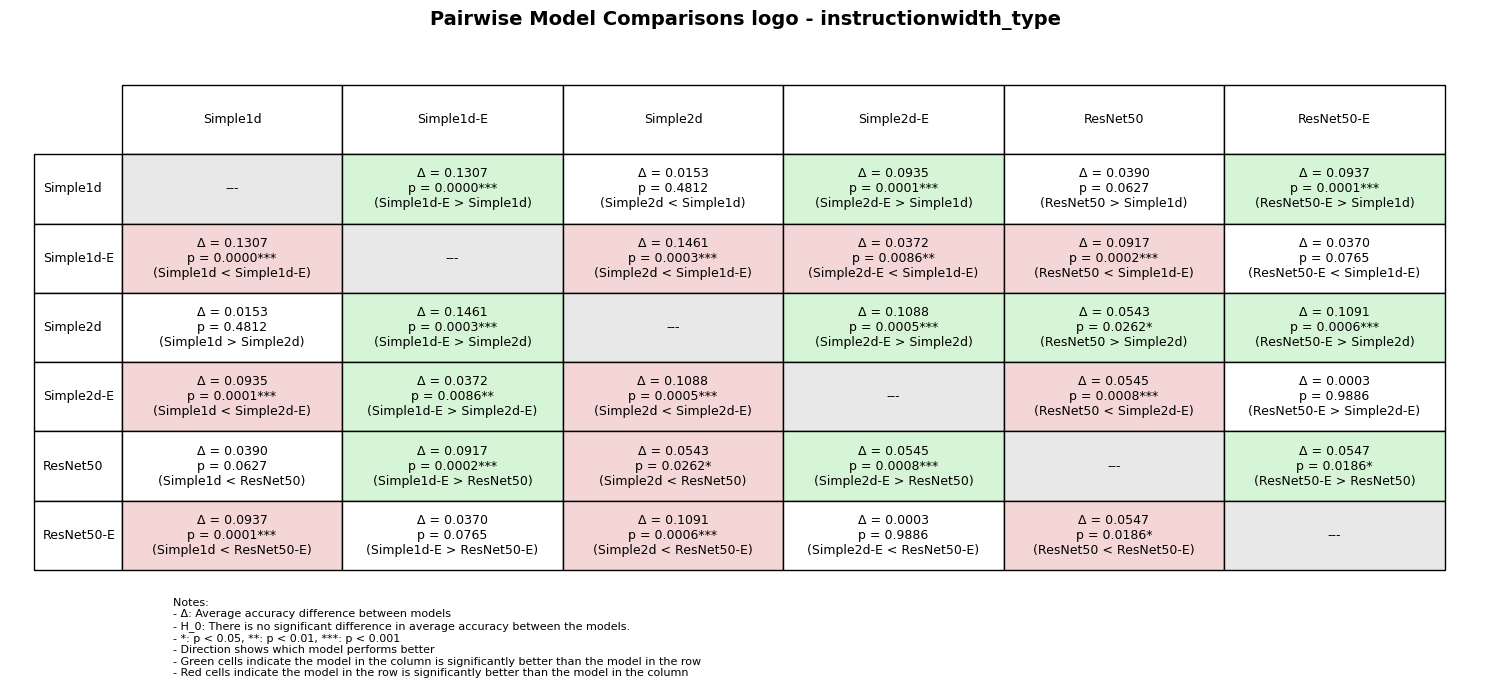

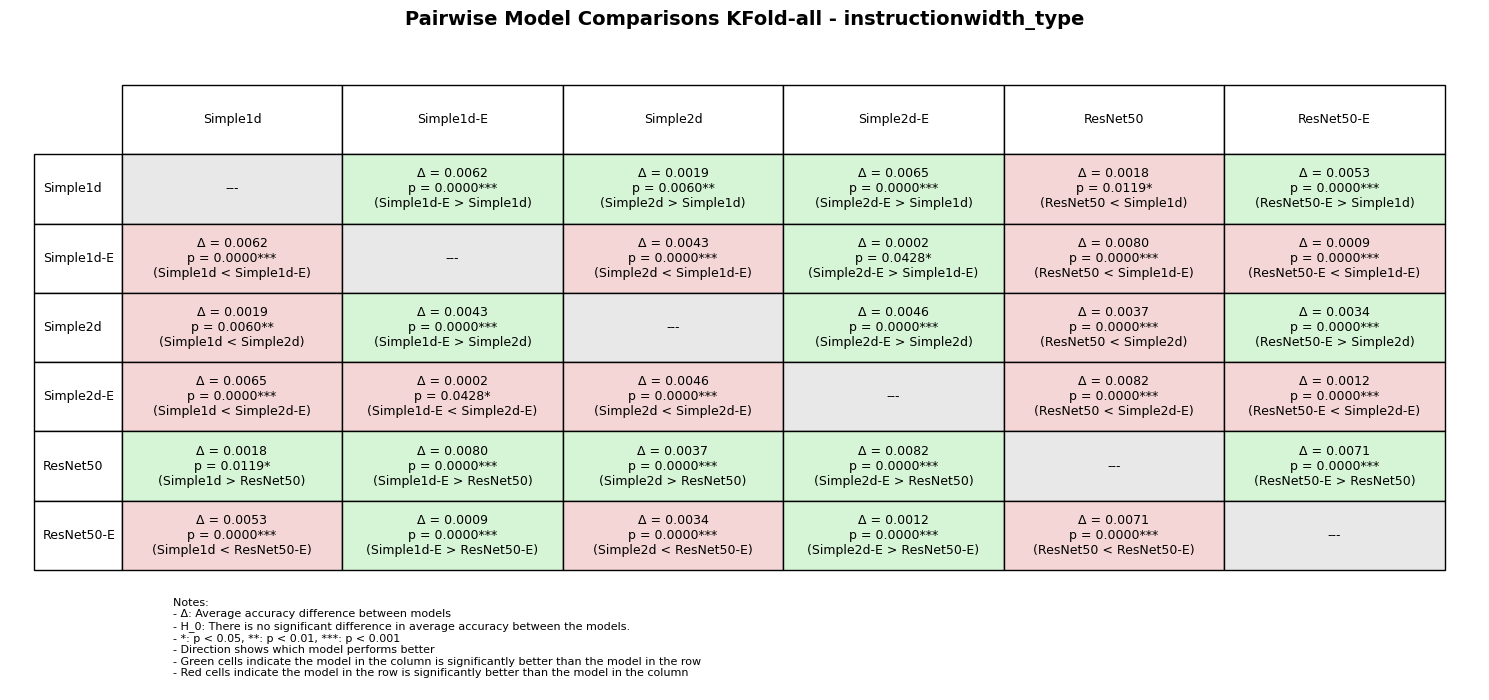

In [2]:
for target_feature in target_features:
    for cross_validation_suite in cross_validation_suites:
        csv_files = glob.glob(os.path.join(directory, cross_validation_suite))
        df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

        model_comparisons = {}
        for model_name in model_names:
            model_label = model_name.replace("Embedding", "-E")
            df = df_all[
                (df_all["model.name"] == model_name)
                & (df_all["target_feature"] == target_feature)
            ].reset_index(drop=True)

            # Filter out rows with Name "overall_metrics"
            df_filtered = df[df["Name"] != "overall_metrics"]

            # Group by the seed column and create a list of accuracies
            accuracies_per_run_per_fold_lists = (
                df_filtered.groupby("validator.seed")["test_accuracy_chunk"]
                .apply(list)
                .tolist()
            )

            # Group by the seed column and create a list of dataset sizes
            fold_sample_counts = (
                df_filtered.groupby("validator.seed")["test_dataset_size"]
                .apply(list)
                .tolist()
            )
            model_comparisons[model_label] = {model_label: None}
            for other_model_name in model_names:
                if other_model_name == model_name:
                    continue
                other_model_label = other_model_name.replace("Embedding", "-E")
                other_df = df_all[
                    (df_all["model.name"] == other_model_name)
                    & (df_all["target_feature"] == target_feature)
                ].reset_index(drop=True)

                # Filter out rows with Name "overall_metrics"
                other_df_filtered = other_df[other_df["Name"] != "overall_metrics"]

                # Group by the seed column and create a list of accuracies
                other_accuracies_per_run_per_fold_lists = (
                    other_df_filtered.groupby("validator.seed")["test_accuracy_chunk"]
                    .apply(list)
                    .tolist()
                )

                # Group by the seed column and create a list of dataset sizes
                other_fold_sample_counts = (
                    other_df_filtered.groupby("validator.seed")["test_dataset_size"]
                    .apply(list)
                    .tolist()
                )

                # Compare the accuracies of the two models
                comparison_result = compare_logo_cv_models(
                    accuracies_per_run_per_fold_lists,
                    other_accuracies_per_run_per_fold_lists,
                    fold_sample_counts,
                    other_fold_sample_counts,
                )
                model_comparisons[model_label][other_model_label] = comparison_result

        # Example usage with your existing code
        fig = plot_model_comparison_table(
            model_comparisons,
            title=f"Pairwise Model Comparisons {cross_validation_suite.replace(".csv", "").replace("-All", "").replace("LOGO-*", "logo")} - {target_feature}",
        )
        plt.savefig(
            f"output/model-comparison-{cross_validation_suite.replace(".csv", "").replace("-All", "").replace("LOGO-*", "logo").lower()}-{target_feature.replace("_", "")}.svg",
            bbox_inches="tight",
        )

### Train Test Eval


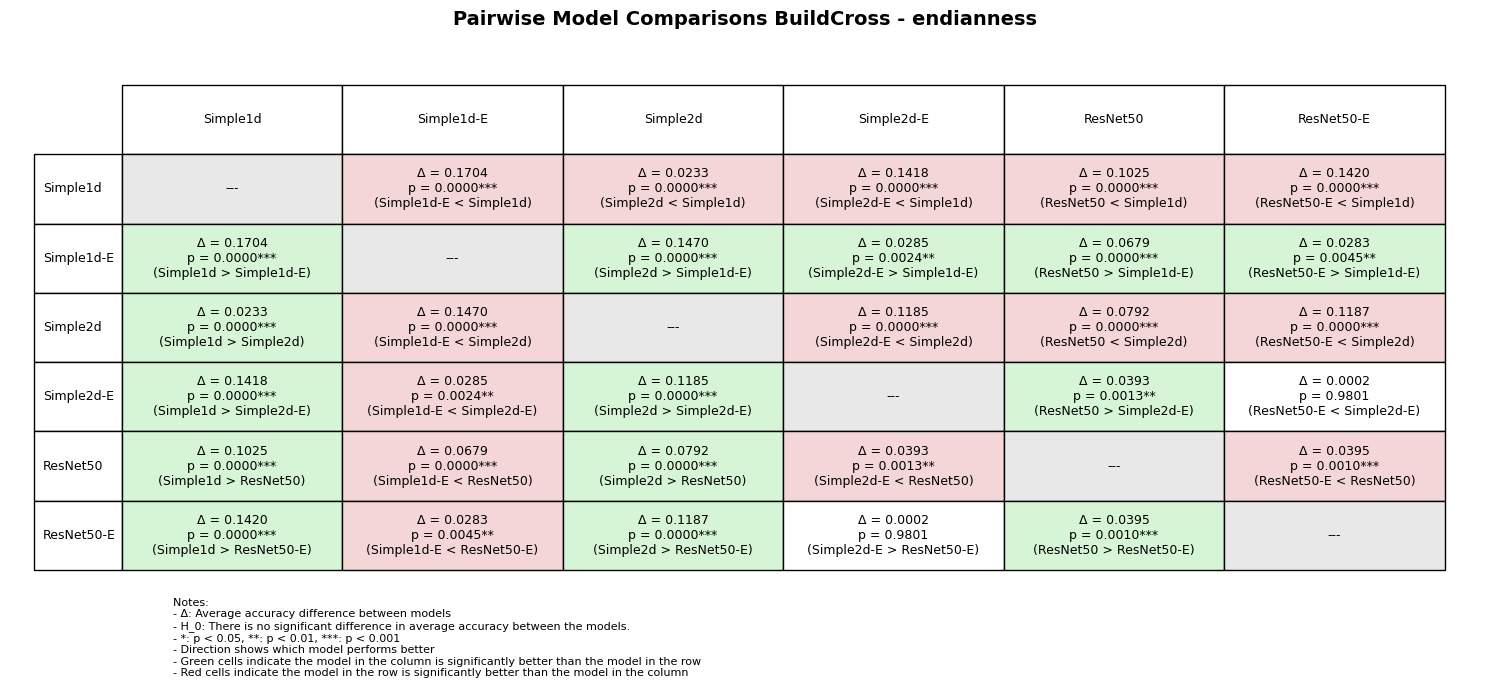

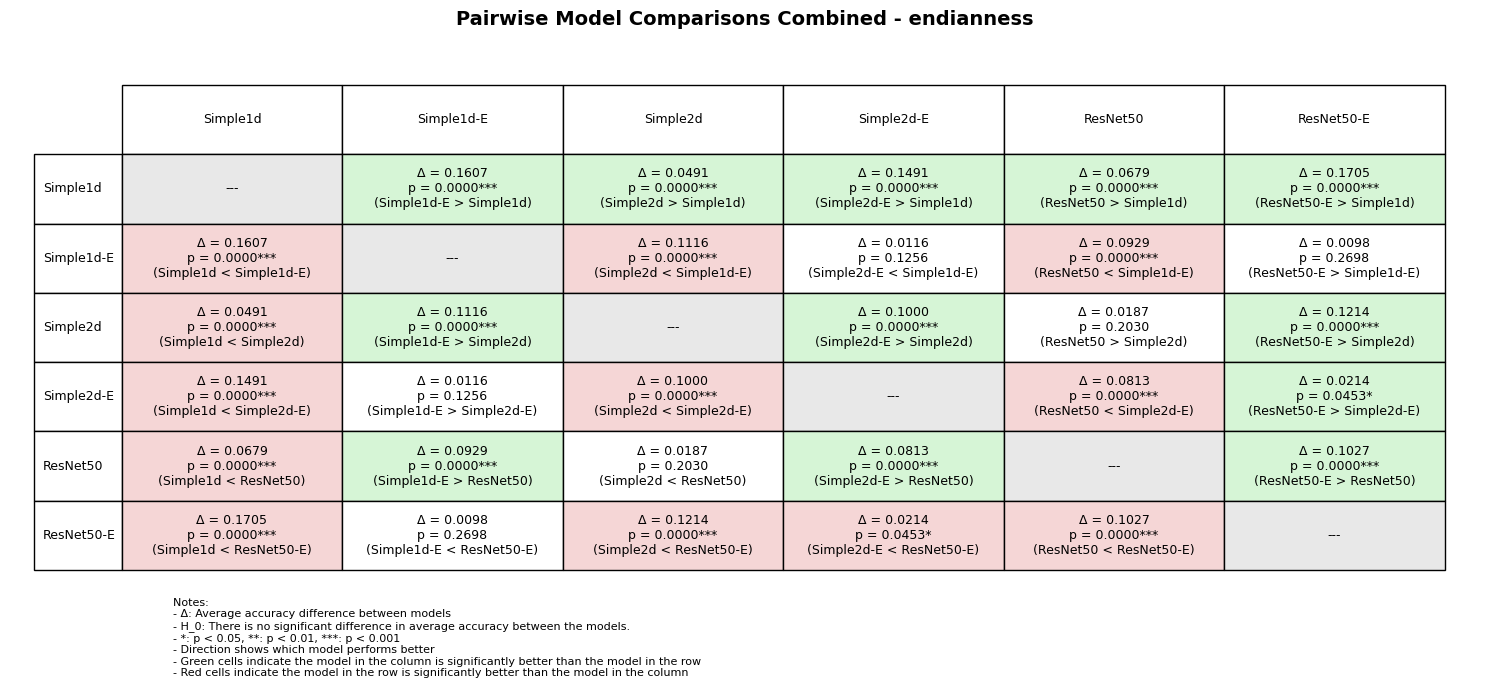

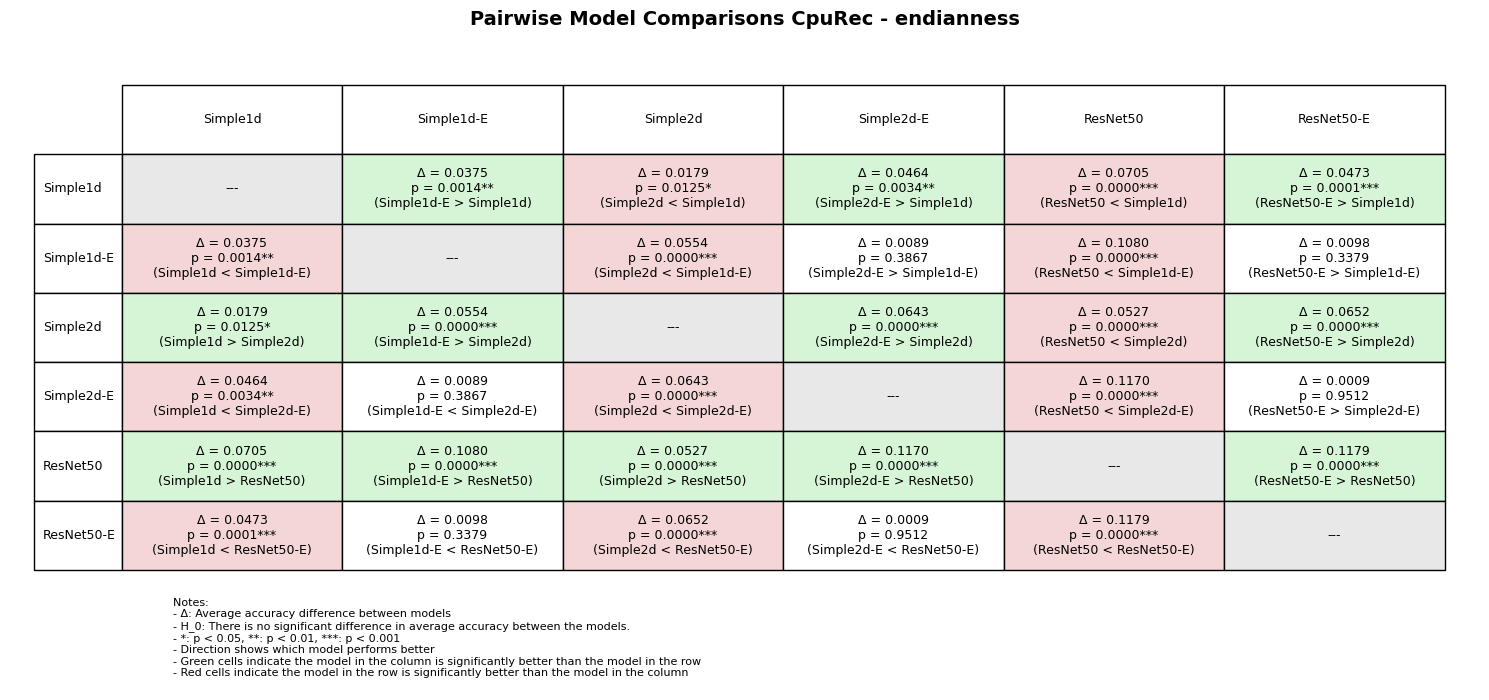

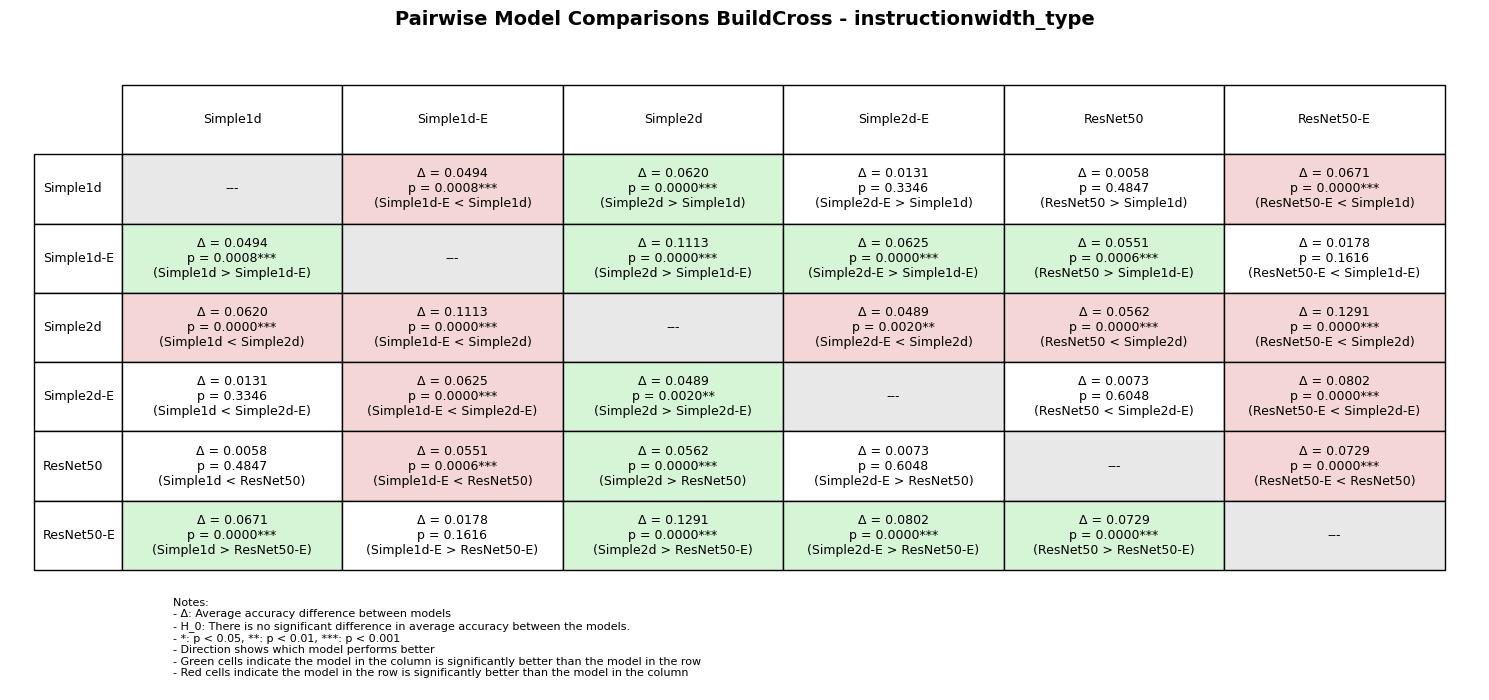

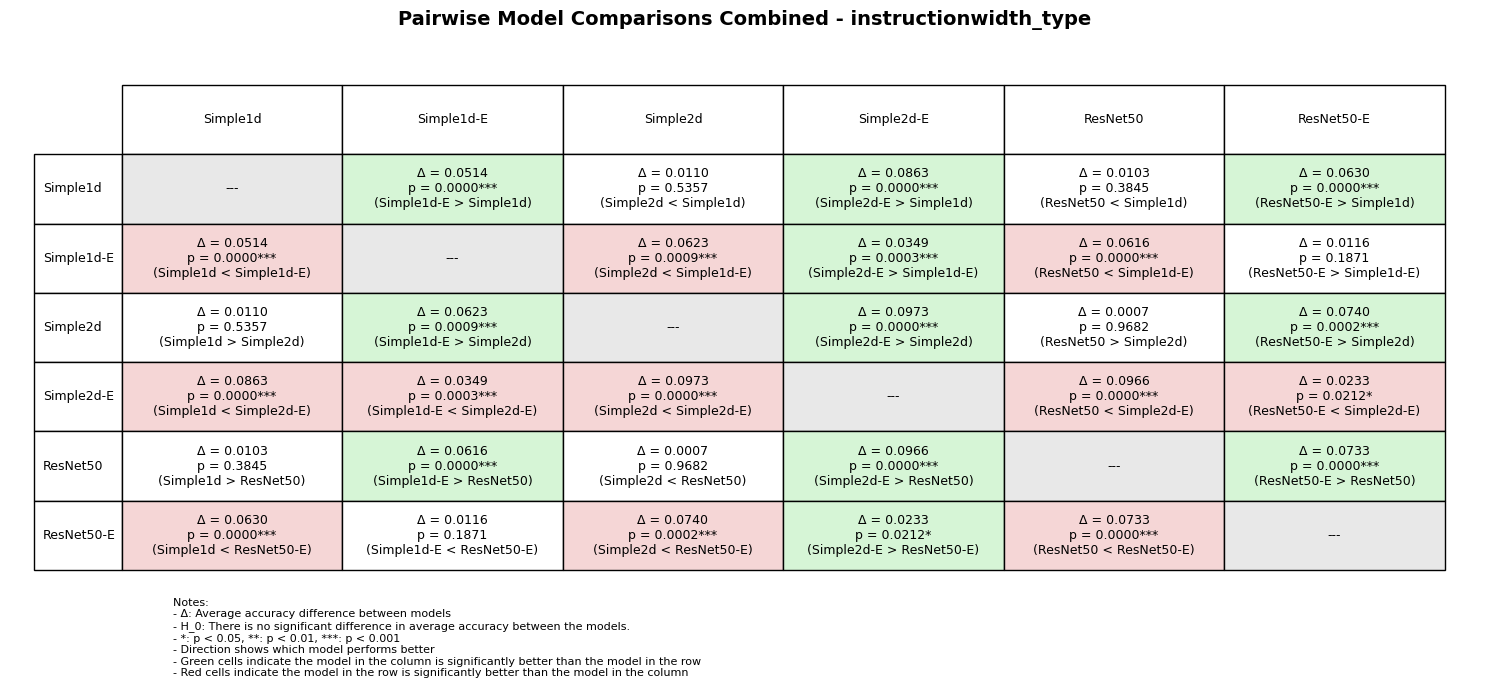

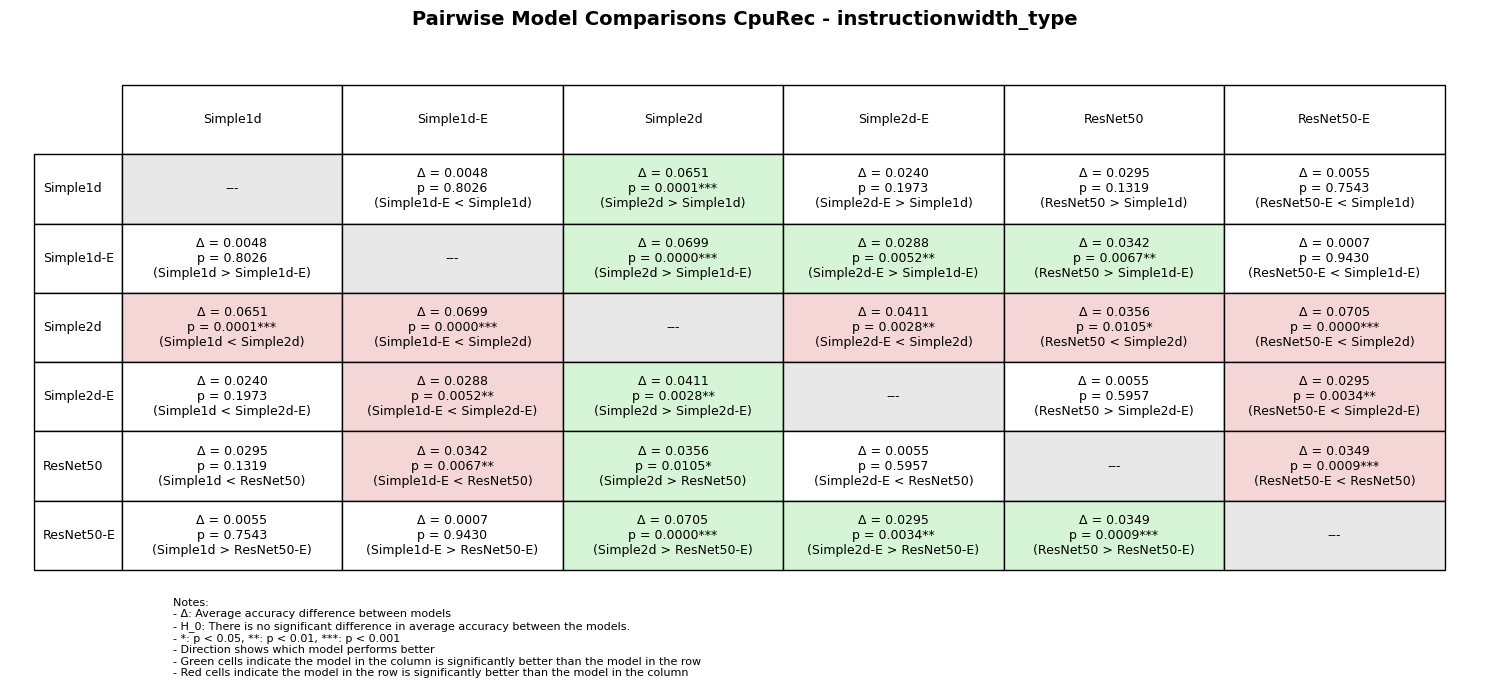

In [3]:
for target_feature in target_features:
    for train_test_suite in train_test_suites:
        csv_files = glob.glob(os.path.join(directory, train_test_suite))
        df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

        model_comparisons = {}
        for model_name in model_names:
            model_label = model_name.replace("Embedding", "-E")
            df = df_all[
                (df_all["validator.name"] == "train_test_separate_datasets")
                & (df_all["model.name"] == model_name)
                & (df_all["target_feature"] == target_feature)
            ].reset_index(drop=True)

            samples_count_cols = [
                col for col in df.columns if col.startswith("instance_count_")
            ]
            df["total_samples_count"] = df[samples_count_cols].sum(axis=1).astype(int)
            assert (
                df["total_samples_count"] == df["total_samples_count"].iloc[0]
            ).all(), "Not all rows have the same samples count."

            samples_per_run = int(df["total_samples_count"].iloc[0])
            run_accuracies = df["test_accuracy"].tolist()
            model_comparisons[model_label] = {model_label: None}
            for other_model_name in model_names:
                if other_model_name == model_name:
                    continue

                other_model_label = other_model_name.replace("Embedding", "-E")

                other_df = df_all[
                    (df_all["validator.name"] == "train_test_separate_datasets")
                    & (df_all["model.name"] == other_model_name)
                    & (df_all["target_feature"] == target_feature)
                ].reset_index(drop=True)

                other_run_accuracies = other_df["test_accuracy"].tolist()
                model_comparisons[model_label][other_model_label] = (
                    compare_model_accuracies(run_accuracies, other_run_accuracies)
                )

        # Example usage with your existing code
        fig = plot_model_comparison_table(
            model_comparisons,
            title=f"Pairwise Model Comparisons {train_test_suite.replace(".csv", "").replace("-All", "")} - {target_feature}",
        )
        plt.savefig(
            f"output/model-comparison-{train_test_suite.replace(".csv", "").replace("-All", "").lower()}-{target_feature.replace("_", "")}.svg",
            bbox_inches="tight",
        )